In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense,Input,Flatten,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from keras.models import Model,load_model ,Sequential
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [4]:
# Basemodel refers to the Model trained on 62 classes in Part1 which will be used as pretrained model for the rest of the tasks.
# mnist1 refers to data used from Task1 for numbers 0-9 ,i.e. Sample001-Sample010
# mnist 2 refers to data used from http://yann.lecun.com/exdb/mnist/ 
# mnist 3 refers to data used in Task2 part 3
# random refers to Randomly Initialised Models
# pretrained refers to Models using Pretrained Weights

In [5]:
basemodel_path = '/content/drive/MyDrive/IIITD/Basemodel.h5'
random_mnist1_path = '/content/drive/MyDrive/IIITD/random_mnist1.h5'
pretrained_mnist1_path = '/content/drive/MyDrive/IIITD/pretrained_mnist1.h5'
random_mnist2_path = '/content/drive/MyDrive/IIITD/random_mnist2.h5'
pretrained_mnist2_path = '/content/drive/MyDrive/IIITD/pretrained_mnist2.h5'
random_mnist3_path= '/content/drive/MyDrive/IIITD/random_mnist3.h5'
pretrained_mnist3_path = '/content/drive/MyDrive/IIITD/pretrained_mnist3.h5'

In [6]:
checkpoint_basemodel = '/content/drive/MyDrive/IIITD/basemodel'
checkpoint_random_mnist1 = '/content/drive/MyDrive/IIITD/checkpoint_random_mnist1'
checkpoint_pretrained_mnist1 = '/content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist1'
checkpoint_random_mnist2 = '/content/drive/MyDrive/IIITD/checkpoint_random_mnist2'
checkpoint_pretrained_mnist2 = '/content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist2'
checkpoint_random_mnist3 = '/content/drive/MyDrive/IIITD/checkpoint_random_mnist3'
checkpoint_pretrained_mnist3 = '/content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist3'

In [7]:
def arrayprocess(X,y,n_class):
  X = np.array(X)
  y = np.array(y)
  X,y = shuffle(X,y)
  encoder = LabelEncoder()
  y  =encoder.fit_transform(y.reshape(-1,1))
  y = to_categorical(y,n_class)
  return X,y

In [8]:
def create_basemodel(n_class):
  model = Sequential()
  model.add(Conv2D(32,kernel_size=3,padding='same',activation='relu',input_shape=(28,28,1)))
  model.add(MaxPooling2D(padding='same' ))
  model.add(Dropout(0.15))
  model.add(Conv2D(64,kernel_size=3,padding='same',activation='relu'))
  model.add(MaxPooling2D( padding='same'))
  model.add(Dropout(0.2))
  model.add(Conv2D(64,kernel_size=3,padding='same',activation='relu'))
  model.add(MaxPooling2D(padding='same'))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(units =256, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.35))
  model.add(Dense(units = n_class, activation = 'softmax'))
  model.compile(optimizer = Adam( learning_rate=0.001,), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  model.summary()
  return model


In [9]:
batch_size = 32
epochs = 50
img_height = 28
img_width = 28

In [10]:
def create_callbacks(checkpoint_path):

  reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=3,factor=0.1,min_lr=0.00001)
  early_stopping = EarlyStopping(monitor='val_loss',restore_best_weights=True,patience = 5)
  modelcheckpoint = ModelCheckpoint(checkpoint_path, monitor="val_loss",verbose=3,save_best_only=False,save_weights_only=False,save_freq="epoch")
  callback = [reduce_learning_rate,early_stopping,modelcheckpoint]
  return callback

In [11]:
def plot_loss(model_history):
  plt.plot(model_history.history["loss"], label="train_loss")
  plt.plot(model_history.history["val_loss"], label="val_loss")
  plt.title("Model Training")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.savefig("epochs.png")

In [12]:
def plot_acc(model_history):
  plt.plot(model_history.history["accuracy"], label="train_acc")
  plt.plot(model_history.history["val_accuracy"], label="val_acc")
  plt.title("Model Training")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.savefig("epochs_acc.png")


# Task 2 Part 1


# Importing & Preprocessing Data



In [12]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    rot = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
    first_white_pixel_v, last_white_pixel_v = np.array(np.where(img == 0))[:,[0,-1]].T
    first_white_pixel_h, last_white_pixel_h = np.array(np.where(rot == 0))[:,[0,-1]].T
    img = img[first_white_pixel_v[0]-20:last_white_pixel_v[0]+20,first_white_pixel_h[0]-20:last_white_pixel_h[0]+20]
    img = cv2.resize(img,(img_height,img_width),interpolation=cv2.INTER_AREA)
    img= cv2.copyMakeBorder(img,15,15,15,15,cv2.BORDER_CONSTANT,value=[255,255,255])
    img = 255-img
    img = img  * (1/255)
    img = cv2.resize(img,(img_height,img_width),interpolation=cv2.INTER_AREA)
    img = img.reshape(img_height,img_width,1)
    return(img)


In [13]:
X_part1 = []
y_part1 = []
base_path = '/content/drive/MyDrive/train'
for label in (os.listdir(base_path)):
  for image in (os.listdir(os.path.join(base_path,label))):
    img = cv2.imread(os.path.join(base_path,label,image))
    img = preprocess(img)
    X_part1.append(img)
    y_part1.append(label)

float64


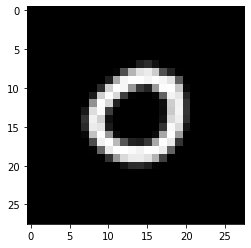

In [16]:
plt.imshow(X_part1[200].reshape(28,28),cmap='gray')
print(X_part1[0].dtype)

In [17]:
X_part1,y_part1 = arrayprocess(X_part1,y_part1,62)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
X_part1_train, X_part1_test, y_part1_train, y_part1_test = train_test_split(X_part1, y_part1, test_size = 0.2, random_state = 42)
X_part1_train.shape,y_part1_train.shape,X_part1_test.shape,y_part1_test.shape

((1984, 28, 28, 1), (1984, 62), (496, 28, 28, 1), (496, 62))

# Model 


In [26]:
basemodel = create_basemodel(62)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)         

In [27]:
hist_basemodel = basemodel.fit(X_part1_train,y_part1_train,batch_size=batch_size,epochs=epochs,steps_per_epoch=len(X_part1_train)/batch_size,shuffle=True,validation_data=(X_part1_test,y_part1_test),callbacks = create_callbacks(checkpoint_basemodel),validation_steps=len(X_part1_test)/batch_size)  

Epoch 1/50
62/62 [==============================] - 5s 63ms/step - loss: 4.0975 - accuracy: 0.0465 - val_loss: 4.0272 - val_accuracy: 0.1633

Epoch 00001: saving model to /content/drive/MyDrive/IIITD/basemodel
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/basemodel/assets
Epoch 2/50
62/62 [==============================] - 4s 64ms/step - loss: 2.7311 - accuracy: 0.3014 - val_loss: 3.6256 - val_accuracy: 0.4819

Epoch 00002: saving model to /content/drive/MyDrive/IIITD/basemodel
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/basemodel/assets
Epoch 3/50
62/62 [==============================] - 4s 61ms/step - loss: 1.8331 - accuracy: 0.5182 - val_loss: 3.0844 - val_accuracy: 0.6613

Epoch 00003: saving model to /content/drive/MyDrive/IIITD/basemodel
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/basemodel/assets
Epoch 4/50
62/62 [==============================] - 4s 59ms/step - loss: 1.3337 - accuracy: 0.6216 - val_loss: 2.4354 - val_acc

# Training Plots


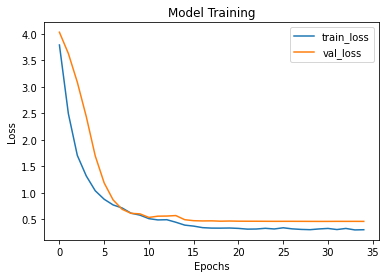

In [28]:
plot_loss(hist_basemodel)

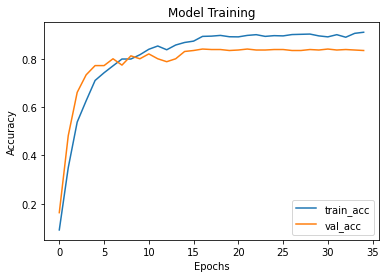

In [29]:
plot_acc(hist_basemodel)


In [30]:
basemodel.save(basemodel_path)

# Task 2 Part 2 Data 1


In [31]:
X_mnist1 = []
y_mnist1 = []
labels = ['Sample001','Sample002','Sample003','Sample004','Sample005','Sample006','Sample007','Sample008','Sample009','Sample010']
base_path = '/content/drive/MyDrive/train'
for label in labels:
  print(label)
  for image in (os.listdir(os.path.join(base_path,label))):
    img = cv2.imread(os.path.join(base_path,label,image))
    img = preprocess(img)
    X_mnist1.append(img)
    y_mnist1.append(label)

Sample001
Sample002
Sample003
Sample004
Sample005
Sample006
Sample007
Sample008
Sample009
Sample010


In [32]:
X_mnist1,y_mnist1 = arrayprocess(X_mnist1,y_mnist1,10)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
from sklearn.model_selection import train_test_split
X_mnist1_train, X_mnist1_test,y_mnist1_train, y_mnist1_test = train_test_split(X_mnist1, y_mnist1, test_size = 0.2, random_state = 42)
y_mnist1_train.shape, X_mnist1_train.shape, X_mnist1_test.shape,y_mnist1_test.shape

((320, 10), (320, 28, 28, 1), (80, 28, 28, 1), (80, 10))

In [36]:
random_mnist1 = create_basemodel(10)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)         

In [38]:
hist_random_mnist1 = random_mnist1.fit(X_mnist1_train,y_mnist1_train,batch_size=batch_size,epochs=50,steps_per_epoch=len(X_mnist1_train)/batch_size,shuffle=True,validation_data=(X_mnist1_test,y_mnist1_test),callbacks = create_callbacks(checkpoint_random_mnist1),validation_steps=len(X_mnist1_test)/batch_size)  

Epoch 1/50
10/10 [==============================] - 2s 104ms/step - loss: 2.2657 - accuracy: 0.2036 - val_loss: 2.2679 - val_accuracy: 0.0875

Epoch 00001: saving model to /content/drive/MyDrive/IIITD/checkpoint_random_mnist1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_random_mnist1/assets
Epoch 2/50
10/10 [==============================] - 1s 75ms/step - loss: 1.4707 - accuracy: 0.4974 - val_loss: 2.2180 - val_accuracy: 0.1375

Epoch 00002: saving model to /content/drive/MyDrive/IIITD/checkpoint_random_mnist1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_random_mnist1/assets
Epoch 3/50
10/10 [==============================] - 1s 76ms/step - loss: 1.0702 - accuracy: 0.6832 - val_loss: 2.1575 - val_accuracy: 0.1000

Epoch 00003: saving model to /content/drive/MyDrive/IIITD/checkpoint_random_mnist1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_random_mnist1/assets
Epoch 4/50
10/10 [==================

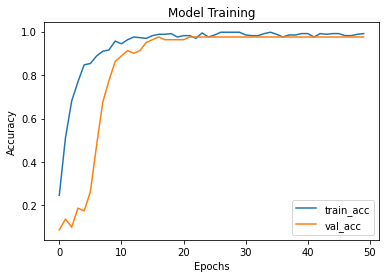

In [39]:
plot_acc(hist_random_mnist1)

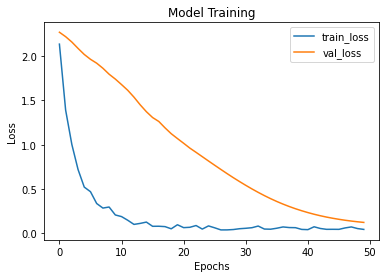

In [40]:
plot_loss(hist_random_mnist1)

In [49]:
random_mnist1.save(random_mnist1_path)


In [42]:
pretrained_mnist1 = load_model(basemodel_path)
pretrained_mnist1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)         

In [43]:
pretrained_mnist1 = Sequential(pretrained_mnist1.layers[:-1])
pretrained_mnist1.add(Dense(units = 10, activation = 'softmax'))
pretrained_mnist1.compile(optimizer = Adam( learning_rate=0.001,), loss = 'categorical_crossentropy', metrics = ['accuracy'])
pretrained_mnist1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)         

In [44]:
hist_pretrain_mnist1 = pretrained_mnist1.fit(X_mnist1_train,y_mnist1_train,batch_size=batch_size,epochs=50,steps_per_epoch=len(X_mnist1_train)/batch_size,shuffle=True,validation_data=(X_mnist1_test,y_mnist1_test),callbacks = create_callbacks(checkpoint_pretrained_mnist1),validation_steps=len(X_mnist1_test)/batch_size)  

Epoch 1/50
10/10 [==============================] - 2s 92ms/step - loss: 2.0692 - accuracy: 0.3506 - val_loss: 0.3762 - val_accuracy: 0.9125

Epoch 00001: saving model to /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist1/assets
Epoch 2/50
10/10 [==============================] - 1s 65ms/step - loss: 0.4629 - accuracy: 0.8794 - val_loss: 0.1910 - val_accuracy: 0.9250

Epoch 00002: saving model to /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist1/assets
Epoch 3/50
10/10 [==============================] - 1s 63ms/step - loss: 0.2077 - accuracy: 0.9435 - val_loss: 0.1548 - val_accuracy: 0.9375

Epoch 00003: saving model to /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist1/assets
Epoch 4/50
10

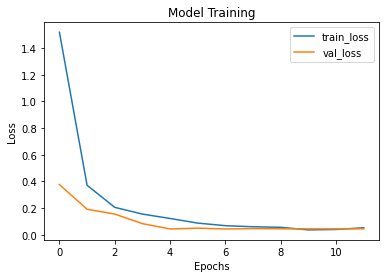

In [45]:
plot_loss(hist_pretrain_mnist1)

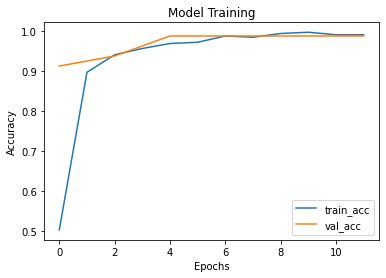

In [46]:
plot_acc(hist_pretrain_mnist1)

In [51]:
pretrained_mnist1.save(pretrained_mnist1_path)


# Task 2 Part 2 Data 2


In [13]:
pip install python-mnist

In [67]:
from mnist import MNIST

mndata = MNIST('/content/drive/MyDrive/samples')

X_train_mnist2, y_train_mnist2 = mndata.load_training()

X_test_mnist2, y_test_mnist2 = mndata.load_testing()

In [68]:
X_train_mnist2,y_train_mnist2 = arrayprocess(X_train_mnist2,y_train_mnist2,10)
X_test_mnist2, y_test_mnist2 = arrayprocess(X_test_mnist2, y_test_mnist2,10)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
X_train_mnist2 = X_train_mnist2.reshape(60000,28,28,1)
X_train_mnist2 = X_train_mnist2 *(1./255)
X_test_mnist2 = X_test_mnist2.reshape(10000,28,28,1)
X_test_mnist2 = X_test_mnist2 *(1./255)


In [70]:
from sklearn.model_selection import train_test_split
X_mnist2_train, X_mnist2_val,y_mnist2_train, y_mnist2_val = train_test_split(X_train_mnist2, y_train_mnist2, test_size = 0.2, random_state = 42)
y_mnist2_train.shape, X_mnist2_train.shape, X_test_mnist2.shape,y_test_mnist2.shape,X_mnist2_val.shape,y_mnist2_val.shape

((48000, 10),
 (48000, 28, 28, 1),
 (10000, 28, 28, 1),
 (10000, 10),
 (12000, 28, 28, 1),
 (12000, 10))

In [71]:
random_mnist2 = create_basemodel(10)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)         

In [72]:
hist_random_mnist2 = random_mnist2.fit(X_mnist2_train,y_mnist2_train,batch_size=batch_size,epochs=50,steps_per_epoch=len(X_mnist2_train)/batch_size,shuffle=True,validation_data=(X_mnist2_val,y_mnist2_val),callbacks =create_callbacks(checkpoint_random_mnist2),validation_steps=len(X_mnist2_val)/batch_size)  

Epoch 1/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3928 - accuracy: 0.8723 - val_loss: 0.0613 - val_accuracy: 0.9794

Epoch 00001: saving model to /content/drive/MyDrive/IIITD/checkpoint_random_mnist2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_random_mnist2/assets
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0839 - accuracy: 0.9746 - val_loss: 0.0495 - val_accuracy: 0.9853

Epoch 00002: saving model to /content/drive/MyDrive/IIITD/checkpoint_random_mnist2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_random_mnist2/assets
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0647 - accuracy: 0.9798 - val_loss: 0.0432 - val_accuracy: 0.9869

Epoch 00003: saving model to /content/drive/MyDrive/IIITD/checkpoint_random_mnist2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_random_mnist2/assets
Epoch 4/50
1500/1500 [======

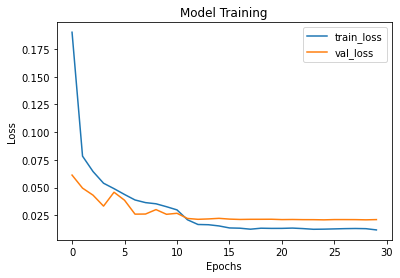

In [73]:
plot_loss(hist_random_mnist2)

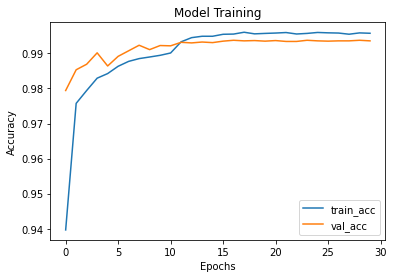

In [74]:
plot_acc(hist_random_mnist2)

In [75]:
random_mnist2.save(random_mnist2_path)

In [76]:
pretrained_mnist2 = load_model('/content/drive/MyDrive/IIITD/Basemodel.h5')
pretrained_mnist2 = Sequential(pretrained_mnist2.layers[:-1])
pretrained_mnist2.add(Dense(units = 10, activation = 'softmax'))
pretrained_mnist2.compile(optimizer = Adam( learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
pretrained_mnist2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)         

In [77]:
hist_pretrained_mnist2 = pretrained_mnist2.fit(X_mnist2_train,y_mnist2_train,batch_size=batch_size,epochs=50,steps_per_epoch=len(X_mnist2_train)/batch_size,shuffle=True,validation_data=(X_mnist2_val,y_mnist2_val),callbacks = create_callbacks(checkpoint_pretrained_mnist2),validation_steps=len(X_mnist2_val)/batch_size)  

Epoch 1/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2667 - accuracy: 0.9176 - val_loss: 0.0661 - val_accuracy: 0.9803

Epoch 00001: saving model to /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist2/assets
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0736 - accuracy: 0.9774 - val_loss: 0.0363 - val_accuracy: 0.9895

Epoch 00002: saving model to /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist2/assets
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0599 - accuracy: 0.9817 - val_loss: 0.0308 - val_accuracy: 0.9909

Epoch 00003: saving model to /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist2/assets
Epoc

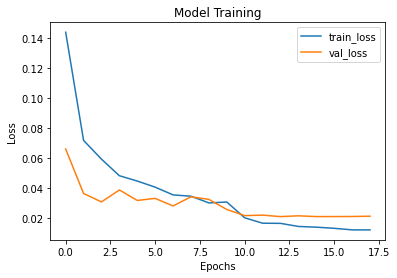

In [78]:
plot_loss(hist_pretrained_mnist2)

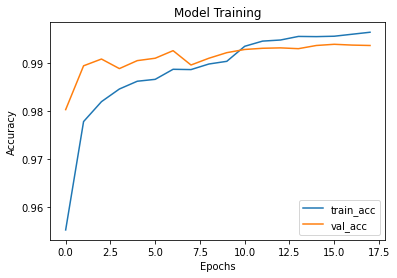

In [79]:
plot_acc(hist_pretrained_mnist2)

In [80]:
pretrained_mnist2.save(pretrained_mnist2_path)

# Task 2 PART 3

In [31]:
!unzip '/content/drive/MyDrive/mnistTask3.zip'

Streaming output truncated to the last 5000 lines.
 extracting: mnistTask/3/image_021488.jpg  
 extracting: mnistTask/3/image_047540.jpg  
 extracting: mnistTask/3/image_050475.jpg  
 extracting: mnistTask/3/image_024391.jpg  
 extracting: mnistTask/3/image_020193.jpg  
 extracting: mnistTask/3/image_004447.jpg  
 extracting: mnistTask/3/image_051601.jpg  
 extracting: mnistTask/3/image_009900.jpg  
 extracting: mnistTask/3/image_020916.jpg  
 extracting: mnistTask/3/image_025962.jpg  
 extracting: mnistTask/3/image_054889.jpg  
 extracting: mnistTask/3/image_012369.jpg  
 extracting: mnistTask/3/image_025528.jpg  
 extracting: mnistTask/3/image_035609.jpg  
 extracting: mnistTask/3/image_037469.jpg  
 extracting: mnistTask/3/image_057560.jpg  
 extracting: mnistTask/3/image_000119.jpg  
 extracting: mnistTask/3/image_020120.jpg  
 extracting: mnistTask/3/image_044129.jpg  
 extracting: mnistTask/3/image_027779.jpg  
 extracting: mnistTask/3/image_058235.jpg  
 extracting: mnistTask/3/

In [32]:
X_mnist3 = []
y_mnist3 = []
base_path = '/content/mnistTask'
for label in (os.listdir(base_path)):
  print(label)
  for image in (os.listdir(os.path.join(base_path,label))):
    img = cv2.imread(os.path.join(base_path,label,image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.resize(img,(img_height,img_width),interpolation=cv2.INTER_AREA)
    # print(img.shape)
    img = img.reshape(img_height,img_width,1)
    img = img * (1./255)
    X_mnist3.append(img)
    y_mnist3.append(label)

4
8
3
5
0
2
7
1
9
6


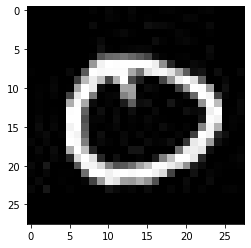

In [34]:
plt.imshow(X_mnist3[10].reshape(28,28),cmap='gray')

In [35]:
X_mnist3,y_mnist3 = arrayprocess(X_mnist3,y_mnist3,10)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
from sklearn.model_selection import train_test_split
X_mnist3_train, X_mnist3_test, y_mnist3_train, y_mnist3_test = train_test_split(X_mnist3, y_mnist3, test_size = 0.17, random_state = 42)
X_mnist3_train.shape,y_mnist3_train.shape,X_mnist3_test.shape,y_mnist3_test.shape

((49800, 28, 28, 1), (49800, 10), (10200, 28, 28, 1), (10200, 10))

In [37]:
random_mnist3 = create_basemodel(10)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)         

In [40]:
hist_random_mnist3 = random_mnist3.fit(X_mnist3_train,y_mnist3_train,batch_size=batch_size,epochs=20,steps_per_epoch=len(X_mnist3_train)/batch_size,shuffle=True,validation_data=(X_mnist3_test,y_mnist3_test),callbacks = create_callbacks(checkpoint_random_mnist3),validation_steps=len(X_mnist3_test)/batch_size)  

Epoch 1/20
1556/1556 [==============================] - 7s 5ms/step - loss: 2.2923 - accuracy: 0.1100 - val_loss: 2.2907 - val_accuracy: 0.1131

Epoch 00001: saving model to /content/drive/MyDrive/IIITD/checkpoint_random_mnist3
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_random_mnist3/assets
Epoch 2/20
1556/1556 [==============================] - 7s 4ms/step - loss: 2.2876 - accuracy: 0.1099 - val_loss: 2.2779 - val_accuracy: 0.1089

Epoch 00002: saving model to /content/drive/MyDrive/IIITD/checkpoint_random_mnist3
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_random_mnist3/assets
Epoch 3/20
1556/1556 [==============================] - 7s 5ms/step - loss: 2.2852 - accuracy: 0.1104 - val_loss: 2.2819 - val_accuracy: 0.1086

Epoch 00003: saving model to /content/drive/MyDrive/IIITD/checkpoint_random_mnist3
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_random_mnist3/assets
Epoch 4/20
1556/1556 [======

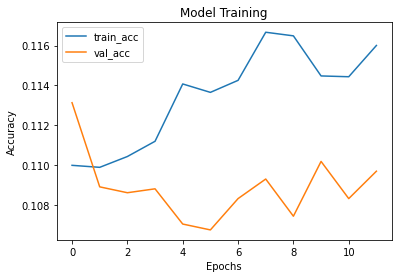

In [41]:
plot_acc(hist_random_mnist3)

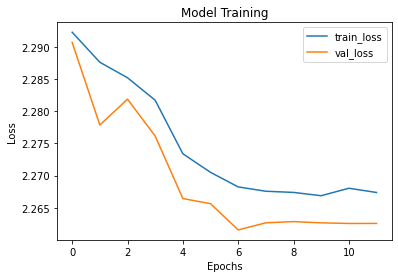

In [42]:
plot_loss(hist_random_mnist3)

In [43]:
random_mnist3.save(random_mnist3_path)

In [44]:
pretrained_mnist3 = load_model('/content/drive/MyDrive/IIITD/Basemodel.h5')
pretrained_mnist3 = Sequential(pretrained_mnist3.layers[:-1])
pretrained_mnist3.add(Dense(units = 10, activation = 'softmax'))
pretrained_mnist3.compile(optimizer = Adam( learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
pretrained_mnist3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)         

In [45]:
hist_pretrained_mnist3 = pretrained_mnist3.fit(X_mnist3_train,y_mnist3_train,batch_size=batch_size,epochs=20,steps_per_epoch=len(X_mnist3_train)/batch_size,shuffle=True,validation_data=(X_mnist3_test,y_mnist3_test),callbacks = create_callbacks(checkpoint_pretrained_mnist3),validation_steps=len(X_mnist3_test)/batch_size)  

Epoch 1/20
1556/1556 [==============================] - 8s 5ms/step - loss: 2.4362 - accuracy: 0.1063 - val_loss: 2.2901 - val_accuracy: 0.1100

Epoch 00001: saving model to /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist3
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist3/assets
Epoch 2/20
1556/1556 [==============================] - 7s 5ms/step - loss: 2.2905 - accuracy: 0.1128 - val_loss: 2.2859 - val_accuracy: 0.1107

Epoch 00002: saving model to /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist3
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist3/assets
Epoch 3/20
1556/1556 [==============================] - 7s 5ms/step - loss: 2.2856 - accuracy: 0.1106 - val_loss: 2.2765 - val_accuracy: 0.1055

Epoch 00003: saving model to /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist3
INFO:tensorflow:Assets written to: /content/drive/MyDrive/IIITD/checkpoint_pretrained_mnist3/assets
Epoc

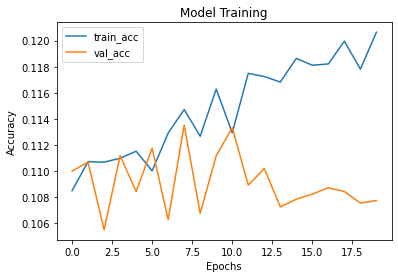

In [46]:
plot_acc(hist_pretrained_mnist3)

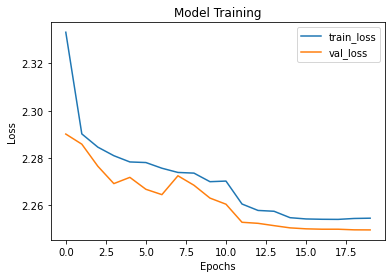

In [47]:
plot_loss(hist_pretrained_mnist3)

In [48]:
pretrained_mnist3.save(pretrained_mnist3_path)

In [50]:
pretrained_mnist3.evaluate(X_mnist3_test,y_mnist3_test,batch_size=  batch_size)

319/319 [==============================] - 1s 3ms/step - loss: 2.2496 - accuracy: 0.1077


[2.249606132507324, 0.10774509608745575]